In [1]:
import os
import shutil
import string
import nltk
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
from wordcloud import WordCloud

# Document corpus
#### For the sake of initial implementation and correctness check, we will implement a small **document corpus**, consisting of four original texts, and four of their plagiarisations of various degress.

#### This will later be chnaged into large corpus loading.

#### **NOTE**: LSA does not require labeling, and will process documents as if they're the same. It is here for the comfort of testing and evaluation metrics.

In [2]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def write_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(content)

def main():
    base_dir = "corpus"
    originals_dir = os.path.join(base_dir, "originals")
    plagiarism_dir = os.path.join(base_dir, "plagiarism")
    create_directory(originals_dir)
    create_directory(plagiarism_dir)

    original_texts = {
        "original1.txt": (
            "In recent years, the rapid advancements in artificial intelligence have revolutionized many sectors of the economy. "
            "The development of machine learning algorithms has led to significant improvements in data analysis, predictive modeling, and automation. "
            "This transformative wave is not only enhancing efficiency but also opening up new avenues for innovation."
        ),
        "original2.txt": (
            "The natural world is facing unprecedented challenges due to climate change and human activity. "
            "Scientists continue to study the intricate balance of ecosystems, striving to understand how flora and fauna adapt to shifting environmental conditions. "
            "Such research is critical for devising strategies to mitigate environmental degradation."
        ),
        "original3.txt": (
            "Literature has long served as a mirror to society, reflecting its values, conflicts, and dreams. "
            "Through a diverse range of narratives, authors explore the complexities of human nature and the eternal struggle between hope and despair. "
            "These stories continue to inspire readers across generations."
        ),
        "original4.txt": (
            "Dogs are very curious creatures, often jumping around and looking for new fun corners to inhabitate."
        ),
    }
    
    for filename, text in original_texts.items():
        filepath = os.path.join(originals_dir, filename)
        write_file(filepath, text)
    
    plagiarism_texts = {
        "plagiarism1.txt": (
            "In recent years, the rapid developments in artificial intelligence have revolutionized various sectors of the economy. "
            "The progress in machine learning algorithms has resulted in notable improvements in data analysis, predictive modeling, and automation. "
            "This transformative trend is not only boosting efficiency but also opening up new avenues for innovation."
        ),
        "plagiarism2.txt": (
            "Human activity and climate change are imposing unprecedented strains on the natural environment. "
            "Researchers are deeply engaged in exploring the delicate balance of ecosystems, aiming to uncover how plants and animals adjust to changing environmental conditions. "
            "This line of inquiry is essential for developing effective measures to prevent further ecological damage."
        ),
        "plagiarism3.txt": (
            "For centuries, literature has reflected the ethos of society, mirroring its values, struggles, and aspirations. "
            "Through various forms of storytelling, writers delve into the intricacies of human behavior and the persistent battle between optimism and sorrow. "
            "These narratives continue to captivate audiences across time."
        ),
        "plagiarism4.txt": (
            "Owners of dogs showcase great concern for fur consistency, visiting vets and other specialists."
        ),
    }

    for filename, text in plagiarism_texts.items():
        filepath = os.path.join(plagiarism_dir, filename)
        write_file(filepath, text)
    print("Corpus created successfully.")

if __name__ == "__main__":
    main()

Corpus created successfully.


# Document preprocessing

#### The next step is **document preprocessing**. In this snippet, the script reads each text file from the corpus, converts the text to lowercase, removes punctuation, tokenizes it into words, filters out common English stop words, and applies **lemmatization** to reduce words to their base forms. The preprocessed output is then saved in a separate directory structure.

#### Lemmatization, essentially, is the process of grouping together different inflected forms of the same word. For example, `{was}` -> (to) be, `{building, builder}` -> build.

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def process_corpus(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(input_dir, filename)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file: ##
                text = file.read()
            tokens = preprocess_text(text)
            processed_text = ' '.join(tokens)
            output_path = os.path.join(output_dir, filename)
            with open(output_path, 'w', encoding='utf-8') as outfile:
                outfile.write(processed_text)
            print(f"Processed {filename}")

def remove_folder_if_exists(folder_name):
    if os.path.exists(folder_name) and os.path.isdir(folder_name):
        shutil.rmtree(folder_name)
        print(f"Folder '{folder_name}' succesfully deleted")
    else:
        print(f"Folder '{folder_name}' doesn't exist")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Matrix creation and TF-IDF

#### The next step takes the preprocessed texts and converts them into a term-document matrix using TF-IDF weighting. In this snippet, we load all the processed documents, create a corpus, and then use scikit-learn's `TfidfVectorizer` to compute the **TF-IDF matrix** to measure common words against those that appear rarely.

In [4]:
def load_processed_documents(base_dir="processed"):
    documents = []
    doc_names = []
    for category in ["originals", "plagiarism"]:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(category_path, filename)
                with open(file_path, "r", encoding="utf-8") as file:
                    content = file.read()
                    documents.append(content)
                    doc_names.append(f"{category}/{filename}")
    return documents, doc_names

def create_tfidf_matrix(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix, vectorizer

def display_matrix_info(tfidf_matrix, vectorizer, doc_names, verbose=True):
    df = pd.DataFrame(tfidf_matrix.toarray(), index=doc_names, columns=vectorizer.get_feature_names_out())
    if verbose:
        print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    print("\nTF-IDF Matrix (first 5 rows and 10 columns):")
    print(df.iloc[:5, :10].to_string(header=False, index=False, col_space=10))

# Core Latent Semantic Analysis

#### We start by computing **singular value decomposition (SVD)**, - a factorization of a real or complex matrix into a rotation, followed by a rescaling followed by another rotation. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any `m * n`⁠ matrix. In this sample, we use a manual version of SVD to reduce the dimensionality of our TF-IDF matrix. We also plot the cumulative explained variance to visually determine an appropriate cutoff, for the sake of choosing an optimal `k` (the actual choice is done within the function and its information formula.)

In [5]:
def manual_svd(A, k, tol=1e-6, max_iter=1000):
    m, n = A.shape
    U = np.zeros((m, k))
    sigma = np.zeros(k)
    V = np.zeros((n, k))
    A_copy = A.copy()

    for i in range(k):
        v = np.random.rand(n)
        v = v / np.linalg.norm(v)
        for _ in range(max_iter):
            Av = A_copy.dot(v)
            new_v = A_copy.T.dot(Av)
            norm_new_v = np.linalg.norm(new_v)
            if norm_new_v == 0:
                break
            new_v = new_v / norm_new_v
            if np.linalg.norm(new_v - v) < tol:
                break
            v = new_v

        u = A_copy.dot(v)
        sigma_i = np.linalg.norm(u)
        if sigma_i > tol:
            u = u / sigma_i
        else:
            u = np.zeros_like(u)
        U[:, i] = u
        sigma[i] = sigma_i
        V[:, i] = v
        A_copy = A_copy - sigma_i * np.outer(u, v)
    return U, sigma, V

def choose_optimal_components_manual(sigma, variance_threshold=0.9):
    total_variance = np.sum(sigma**2)
    cumulative_variance = np.cumsum(sigma**2) / total_variance
    optimal_k = np.argmax(cumulative_variance >= variance_threshold) + 1

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.axhline(y=variance_threshold, color='red', linestyle='--', label=f'{variance_threshold*100:.0f}% Variance')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Selecting Optimal Number of Components (Manual SVD)")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Optimal number of components according to manual SVD: {optimal_k}")
    return optimal_k

def perform_lsa_manual(tfidf_matrix, optimal_k):
    A_dense = tfidf_matrix.toarray()
    U, sigma, V = manual_svd(A_dense, optimal_k)
    print("Manual SVD computed.")
    print("Shapes -- U:", U.shape, "Sigma:", sigma.shape, "V:", V.shape)
    return U, sigma, V

# Cosine Similarity

#### We proceed with computing the **similarity scores** among documents in the reduced-dimensional space produced by LSA. We’ll use cosine similarity, which is a common measure for text similarity.
#### The key idea:

- We already have a `reduced_matrix` from the LSA step, where each row corresponds to one document in the corpus, and each column is a latent semantic dimension.

- We also have a **list of document names** (or paths) in `doc_names` that align with the rows of `reduced_matrix`.

- We can calculate **pairwise similarities** among all documents and then check which pairs exceed a chosen threshold.

In [6]:
def cosine_similarity_manual(vec1, vec2):
    dot = 0
    for a, b in zip(vec1, vec2):
        dot += a * b
    norm1 = sum(a * a for a in vec1) ** 0.5
    norm2 = sum(b * b for b in vec2) ** 0.5
    if norm1 == 0 or norm2 == 0:
        return 0
    return dot / (norm1 * norm2)

def pairwise_cosine_similarities(document_vectors, doc_names):
    n = len(document_vectors)
    sim_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = cosine_similarity_manual(document_vectors[i], document_vectors[j])

    df_sim = pd.DataFrame(sim_matrix, index=doc_names, columns=doc_names)
    return df_sim

def compute_query_lsa(query_text, vectorizer, V, sigma):
    query_tfidf = vectorizer.transform([query_text])
    query_dense = query_tfidf.toarray()[0]
    query_projected = query_dense.dot(V)
    query_lsa = query_projected / sigma
    return query_lsa

def compute_cosine_similarities(query_text, vectorizer, V, sigma, document_vectors, doc_names):
    """
    Compute cosine similarity between the query (projected into LSA space) and each document vector.
    """
    query_lsa = compute_query_lsa(query_text, vectorizer, V, sigma)
    similarities = []
    for i, doc_vec in enumerate(document_vectors):
        sim = cosine_similarity_manual(query_lsa, doc_vec)
        similarities.append((doc_names[i], sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

# Main Pipeline
### LSA in action:
#### - To use the custom corpus for basic quick tests - run `"corpus"`.
#### - To see the difference in accuracy with slower, but more nuanced and accurate analysis - run benchmark courpus `"corpus2"` (Files from Pan Corpus 2011)
#### - To test the previous, but in conjuction with evaluation metrics - run `"corpus3"`.

DATA PREPROCESSING>>>>

Folder 'processed' succesfully deleted
Processed original1.txt
Processed original2.txt
Processed original3.txt
Processed original4.txt
Processed plagiarism1.txt
Processed plagiarism2.txt
Processed plagiarism3.txt
Processed plagiarism4.txt


MATRIX CREATION AND TF_IDF>>>>

TF-IDF Matrix Shape: (8, 152)

TF-IDF Matrix (first 5 rows and 10 columns):
  0.000000   0.000000     0.0000        0.0   0.206813        0.0   0.173325   0.173325   0.173325        0.0
  0.000000   0.157391     0.1878        0.0   0.000000        0.0   0.000000   0.000000   0.000000        0.0
  0.170578   0.000000     0.0000        0.0   0.000000        0.0   0.000000   0.000000   0.000000        0.0
  0.000000   0.000000     0.0000        0.0   0.000000        0.0   0.000000   0.000000   0.000000        0.0
  0.000000   0.000000     0.0000        0.0   0.000000        0.0   0.174439   0.174439   0.174439        0.0


CORE LATENT SEMANTIC ANALYSIS>>>>

TF-IDF Matrix Shape: (8, 152)
8
SVD Done

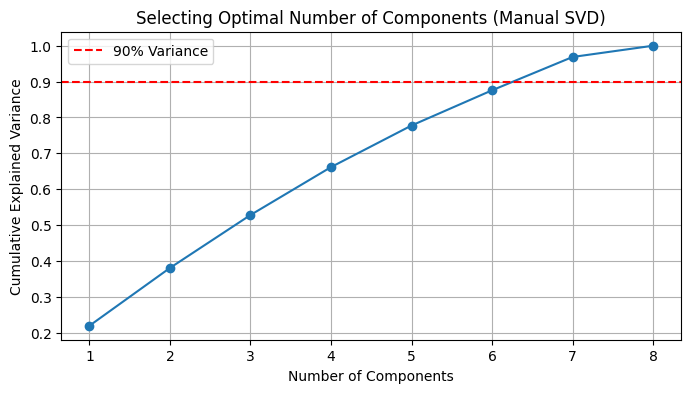

Optimal number of components according to manual SVD: 7
 Optimal_k Done.
Manual SVD computed.
Shapes -- U: (8, 7) Sigma: (7,) V: (152, 7)
U-Sigma-V Done.

Reduced Document Matrix (first 5 rows):
                                   0         1         2         3         4  \
originals/original1.txt     0.933072 -0.020841 -0.026594 -0.036214 -0.028492   
originals/original2.txt     0.003216  0.682709 -0.399688 -0.000834 -0.000065   
originals/original3.txt     0.011805  0.448231  0.636616  0.005940  0.004489   
originals/original4.txt     0.085008 -0.003573 -0.007209  0.721301  0.687329   
plagiarism/plagiarism1.txt  0.933897 -0.007913 -0.006106 -0.035944 -0.028336   

                                   5         6  
originals/original1.txt    -0.027421  0.001248  
originals/original2.txt     0.000621  0.611675  
originals/original3.txt    -0.626836 -0.025912  
originals/original4.txt     0.003485 -0.000117  
plagiarism/plagiarism1.txt  0.007687 -0.000423  


COSINE SIMILARITY>>>>

     

In [7]:
### CORPUS

variance_threshold=0.9 #change as you please - this reflects how much 
# information our reduced matrix should retain. Testing revealed values of 0,7-0,9 to be optimal.

print("DATA PREPROCESSING>>>>")
print("")
corpus_dir = "corpus"
processed_dir = "processed"
categories = ["originals", "plagiarism"]
remove_folder_if_exists(processed_dir)
for category in categories:    
    input_category_dir = os.path.join(corpus_dir, category)
    output_category_dir = os.path.join(processed_dir, category)
    process_corpus(input_category_dir, output_category_dir)
print("")
print("")

print("MATRIX CREATION AND TF_IDF>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
display_matrix_info(tfidf_matrix, vectorizer, doc_names)    
print("")
print("")

print("CORE LATENT SEMANTIC ANALYSIS>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
max_components = tfidf_matrix.shape[0]
print(max_components)
_, sigma_full, _ = manual_svd(tfidf_matrix.toarray(), max_components)
print("SVD Done.")
optimal_k = choose_optimal_components_manual(sigma_full, variance_threshold=variance_threshold)
print(" Optimal_k Done.")
U, sigma, V = perform_lsa_manual(tfidf_matrix, optimal_k)
print("U-Sigma-V Done.")
document_vectors = U * sigma
df = pd.DataFrame(document_vectors, index=doc_names)
print("\nReduced Document Matrix (first 5 rows):")
print(df.head())
print("")
print("")

print("COSINE SIMILARITY>>>>")
print("")
#OPTIONAL!!!!!!!!!!!!!!!
#Change this query to the one you'd like to compare to any document in the corpus.
query_text = ("In recent years, the advancements in artificial intelligence have greatly improved data "
              "analysis and predictive modeling, opening new avenues for innovation.")
df_pairwise1 = pairwise_cosine_similarities(document_vectors, doc_names)
print(df_pairwise1)
similarities1 = compute_cosine_similarities(query_text, vectorizer, V, sigma, document_vectors, doc_names)
print("\nCosine Similarities (query vs. documents):")
for doc, sim in similarities1:
    print(f"{doc}: {sim:.4f}")

# Visualizations for small corpus.

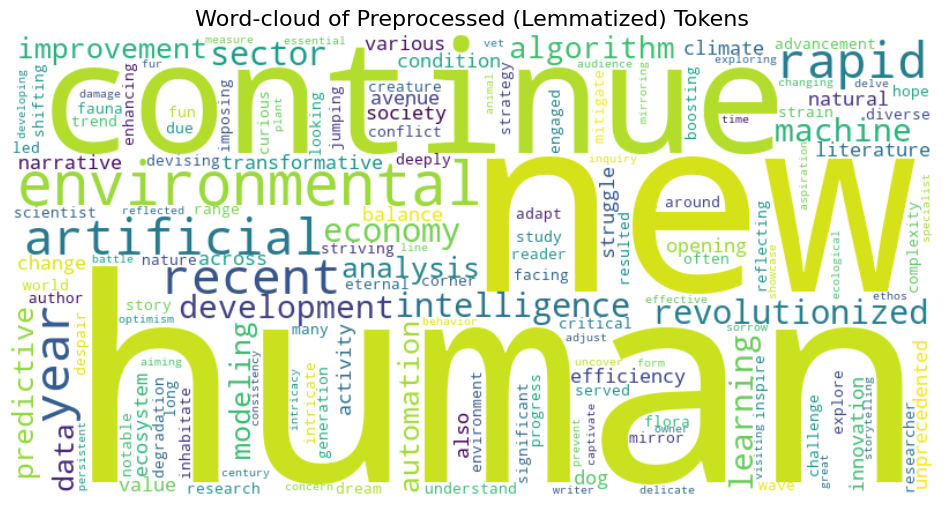

In [8]:
processed_dir = "processed"
all_texts = []
for category in ["originals","plagiarism"]:
    for fp in glob.glob(os.path.join(processed_dir, category, "*.txt")):
        with open(fp, encoding="utf-8") as f:
            all_texts.append(f.read())

tokens = " ".join(all_texts).split()
freqs  = Counter(tokens)
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    max_words=200
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word-cloud of Preprocessed (Lemmatized) Tokens", fontsize=16)
plt.show()

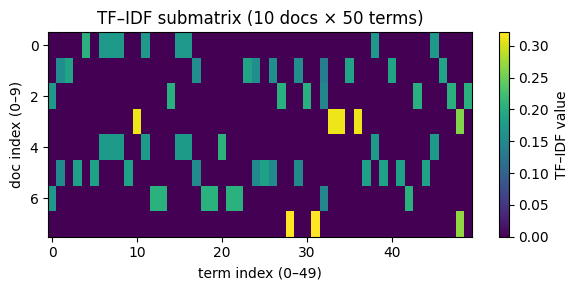

In [9]:
slice_ = tfidf_matrix[:10, :50].toarray()

plt.figure(figsize=(6,3))
plt.imshow(slice_, aspect='auto', interpolation='nearest')
plt.colorbar(label="TF–IDF value")
plt.xlabel("term index (0–49)")
plt.ylabel("doc index (0–9)")
plt.title("TF–IDF submatrix (10 docs × 50 terms)")
plt.tight_layout()
plt.show()


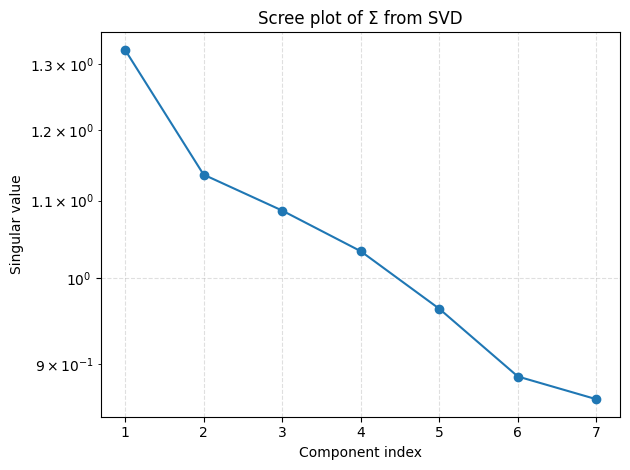

In [10]:
plt.figure()
plt.plot(np.arange(1, len(sigma)+1), sigma, marker='o')
plt.yscale("log")
plt.xlabel("Component index")
plt.ylabel("Singular value")
plt.title("Scree plot of Σ from SVD")
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

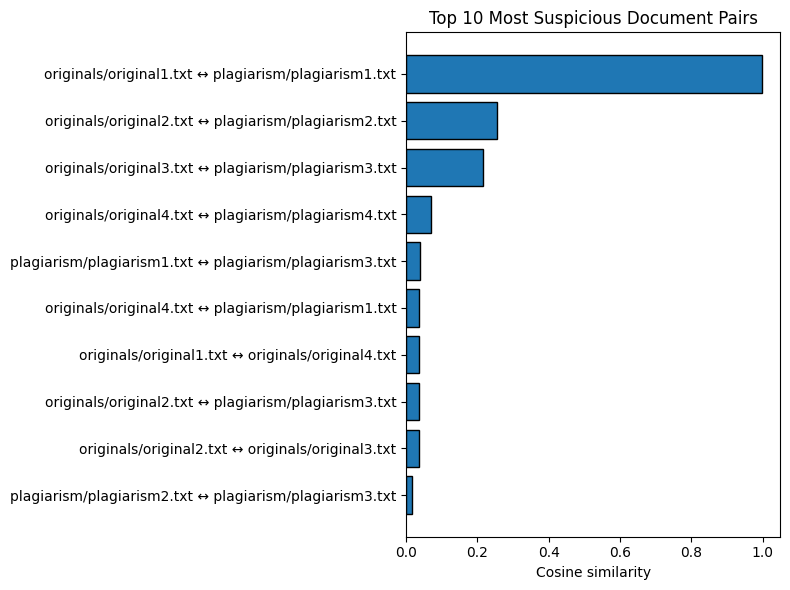

In [11]:
docs = df_pairwise1.index.tolist()
pairs = []
for i in range(len(docs)):
    for j in range(i+1, len(docs)):
        pairs.append(((docs[i], docs[j]), df_pairwise1.iat[i, j]))

pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
top_n = 10
top_pairs = pairs[:top_n]
labels = [f"{i} ↔ {j}" for (i, j), _ in top_pairs]
scores = [score for _, score in top_pairs]

plt.figure(figsize=(8, 6))
bars = plt.barh(labels, scores, edgecolor='k')
plt.xlabel("Cosine similarity")
plt.title(f"Top {top_n} Most Suspicious Document Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

DATA PREPROCESSING>>>>

Folder 'processed' succesfully deleted
Processed source-document00001.txt
Processed source-document00002.txt
Processed source-document00003.txt
Processed source-document00004.txt
Processed source-document00005.txt
Processed source-document00006.txt
Processed source-document00007.txt
Processed source-document00008.txt
Processed source-document00009.txt
Processed source-document00010.txt
Processed source-document00011.txt
Processed source-document00012.txt
Processed source-document00013.txt
Processed source-document00014.txt
Processed source-document00015.txt
Processed source-document00016.txt
Processed source-document00017.txt
Processed source-document00018.txt
Processed source-document00019.txt
Processed source-document00020.txt
Processed source-document00021.txt
Processed source-document00022.txt
Processed source-document00023.txt
Processed source-document00024.txt
Processed source-document00025.txt
Processed source-document00026.txt
Processed source-document00

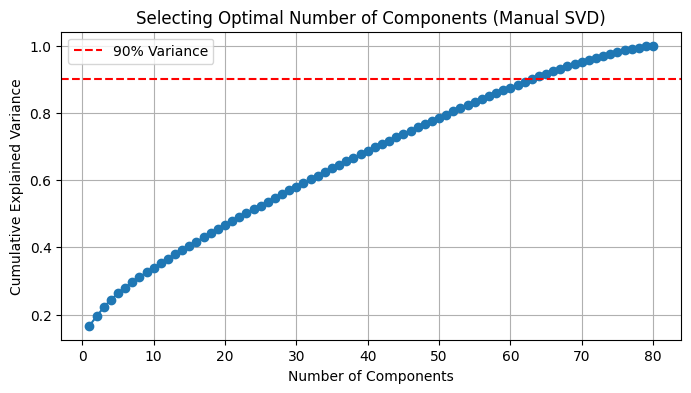

Optimal number of components according to manual SVD: 63
Optimal_k Done.
Manual SVD computed.
Shapes -- U: (80, 63) Sigma: (63,) V: (97619, 63)
U-Sigma-V Done.

Reduced Document Matrix (first 5 rows):
                                          0         1         2         3   \
originals/source-document00001.txt  0.343766  0.007131  0.159796 -0.017337   
originals/source-document00002.txt  0.317194 -0.003121  0.127561 -0.039327   
originals/source-document00003.txt  0.737725 -0.029316 -0.152532  0.006718   
originals/source-document00004.txt  0.662246  0.002128 -0.108776  0.045573   
originals/source-document00005.txt  0.501306 -0.013979 -0.071796  0.001754   

                                          4         5         6         7   \
originals/source-document00001.txt  0.303442  0.253828  0.322633 -0.032560   
originals/source-document00002.txt  0.089306 -0.030294  0.042458  0.178623   
originals/source-document00003.txt -0.072229  0.030187  0.027005  0.024146   
originals/source-d

In [12]:
### CORPUS2
variance_threshold=0.9

print("DATA PREPROCESSING>>>>")
print("")
corpus_dir = "corpus2"
processed_dir = "processed"
categories = ["originals", "plagiarism"]
remove_folder_if_exists(processed_dir)
for category in categories:    
    input_category_dir = os.path.join(corpus_dir, category)
    output_category_dir = os.path.join(processed_dir, category)
    process_corpus(input_category_dir, output_category_dir)
print("")
print("")

print("MATRIX CREATION AND TF_IDF>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
display_matrix_info(tfidf_matrix, vectorizer, doc_names)    
print("")
print("")

print("CORE LATENT SEMANTIC ANALYSIS>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
max_components = tfidf_matrix.shape[0]
print(max_components)
_, sigma_full, _ = manual_svd(tfidf_matrix.toarray(), max_components)
print("SVD Done.")
optimal_k = choose_optimal_components_manual(sigma_full, variance_threshold=variance_threshold)
print("Optimal_k Done.")
U, sigma, V = perform_lsa_manual(tfidf_matrix, optimal_k)
print("U-Sigma-V Done.")
document_vectors = U * sigma
df = pd.DataFrame(document_vectors, index=doc_names)
print("\nReduced Document Matrix (first 5 rows):")
print(df.head())
print("")
print("")

print("COSINE SIMILARITY>>>>")
print("")
query_text = ("In recent years, the advancements in artificial intelligence have greatly improved data "
              "analysis and predictive modeling, opening new avenues for innovation.")
df_pairwise2 = pairwise_cosine_similarities(document_vectors, doc_names)
print(df_pairwise2)
similarities2 = compute_cosine_similarities(query_text, vectorizer, V, sigma, document_vectors, doc_names)
print("\nCosine Similarities (query vs. documents):")
for doc, sim in similarities2:
    print(f"{doc}: {sim:.4f}")

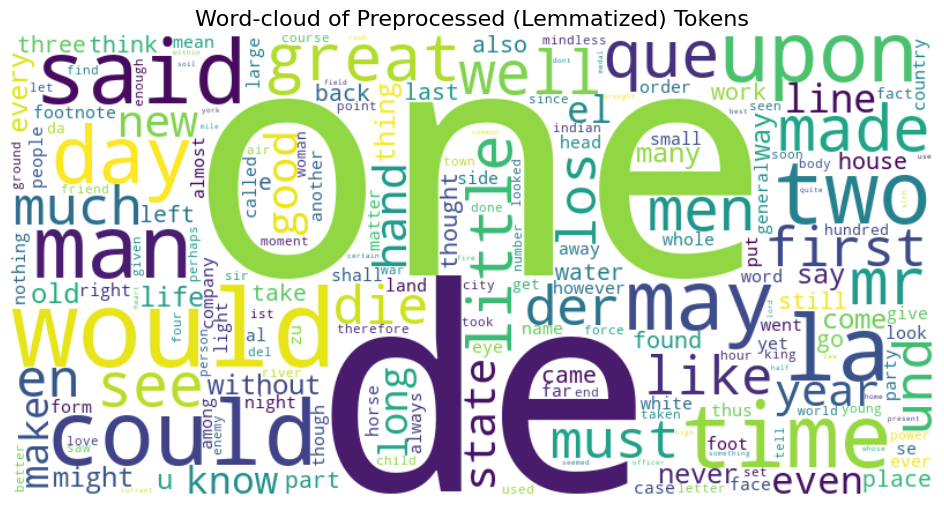

In [13]:
processed_dir = "processed"
all_texts = []
for category in ["originals","plagiarism"]:
    for fp in glob.glob(os.path.join(processed_dir, category, "*.txt")):
        with open(fp, encoding="utf-8") as f:
            all_texts.append(f.read())

tokens = " ".join(all_texts).split()
freqs  = Counter(tokens)
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    max_words=200
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word-cloud of Preprocessed (Lemmatized) Tokens", fontsize=16)
plt.show()

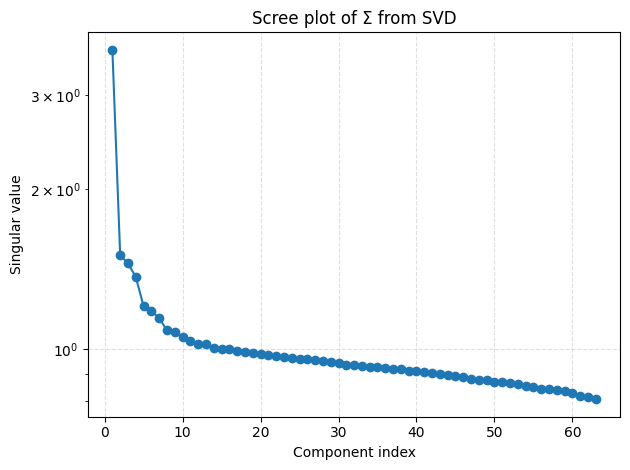

In [14]:
plt.figure()
plt.plot(np.arange(1, len(sigma)+1), sigma, marker='o')
plt.yscale("log")
plt.xlabel("Component index")
plt.ylabel("Singular value")
plt.title("Scree plot of Σ from SVD")
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

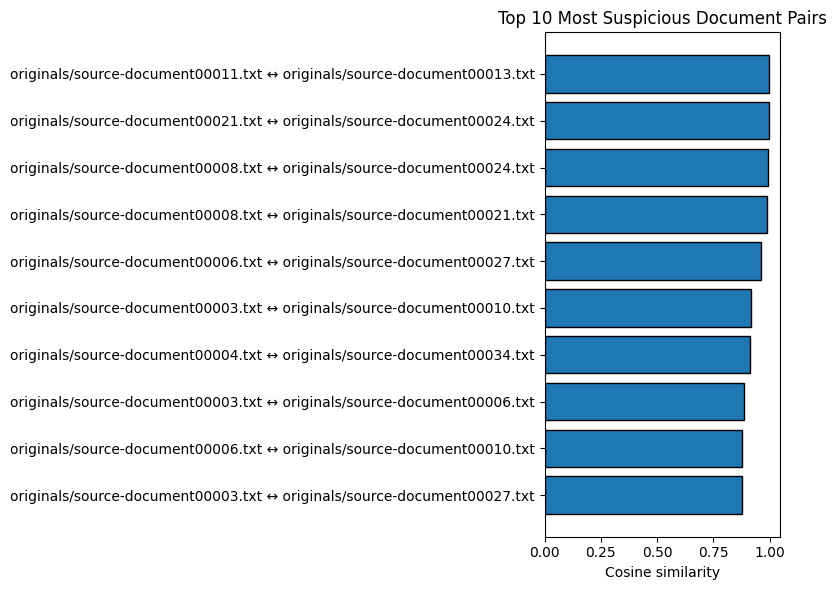

In [15]:
docs = df_pairwise2.index.tolist()
pairs = []
for i in range(len(docs)):
    for j in range(i+1, len(docs)):
        pairs.append(((docs[i], docs[j]), df_pairwise2.iat[i, j]))

pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
top_n = 10
top_pairs = pairs[:top_n]
labels = [f"{i} ↔ {j}" for (i, j), _ in top_pairs]
scores = [score for _, score in top_pairs]

plt.figure(figsize=(8, 6))
bars = plt.barh(labels, scores, edgecolor='k')
plt.xlabel("Cosine similarity")
plt.title(f"Top {top_n} Most Suspicious Document Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

DATA PREPROCESSING>>>>

Folder 'processed' succesfully deleted
Processed orig_taska.txt
Processed orig_taskb.txt
Processed orig_taskc.txt
Processed orig_taskd.txt
Processed orig_taske.txt
Processed g0pA_taska.txt
Processed g0pA_taskb.txt
Processed g0pA_taskc.txt
Processed g0pA_taskd.txt
Processed g0pA_taske.txt
Processed g0pB_taska.txt
Processed g0pB_taskb.txt
Processed g0pB_taskc.txt
Processed g0pB_taskd.txt
Processed g0pB_taske.txt
Processed g0pC_taska.txt
Processed g0pC_taskb.txt
Processed g0pC_taskc.txt
Processed g0pC_taskd.txt
Processed g0pC_taske.txt
Processed g0pD_taska.txt
Processed g0pD_taskb.txt
Processed g0pD_taskc.txt
Processed g0pD_taskd.txt
Processed g0pD_taske.txt
Processed g0pE_taska.txt
Processed g0pE_taskb.txt
Processed g0pE_taskc.txt
Processed g0pE_taskd.txt
Processed g0pE_taske.txt
Processed g1pA_taska.txt
Processed g1pA_taskb.txt
Processed g1pA_taskc.txt
Processed g1pA_taskd.txt
Processed g1pA_taske.txt
Processed g1pB_taska.txt
Processed g1pB_taskb.txt
Processed g1

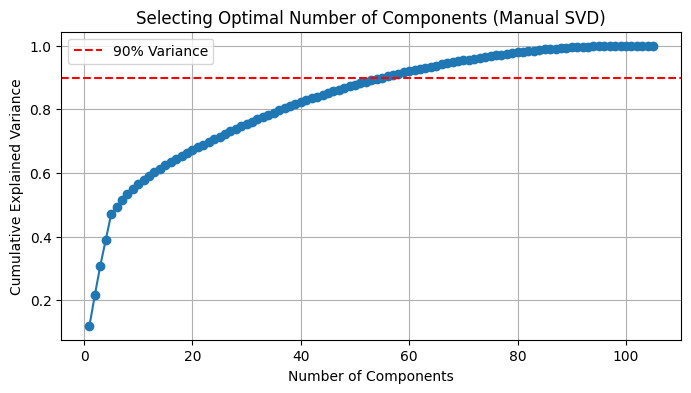

Optimal number of components according to manual SVD: 56
Optimal_k Done.
Manual SVD computed.
Shapes -- U: (105, 56) Sigma: (56,) V: (1826, 56)
U-Sigma-V Done.

Reduced Document Matrix (first 5 rows):
                                0         1         2         3         4   \
originals/orig_taska.txt  0.282036  0.177993  0.518339  0.541014 -0.425035   
originals/orig_taskb.txt  0.292911  0.088046 -0.045576  0.478645  0.716572   
originals/orig_taskc.txt  0.721781 -0.482042 -0.227949 -0.061244 -0.159334   
originals/orig_taskd.txt  0.373747  0.745261 -0.427620 -0.118524 -0.164088   
originals/orig_taske.txt  0.375419  0.143685  0.566776 -0.508073  0.223544   

                                5         6         7         8         9   \
originals/orig_taska.txt -0.320534 -0.015800  0.038149  0.038229 -0.033659   
originals/orig_taskb.txt -0.020908  0.096300 -0.012910  0.013319  0.016363   
originals/orig_taskc.txt  0.000237 -0.002750 -0.043002 -0.195274 -0.235459   
originals/orig_tas

In [16]:
### CORPUS3 - SUITABLE FOR METRICS
variance_threshold=0.9

print("DATA PREPROCESSING>>>>")
print("")
corpus_dir = "corpus3"
processed_dir = "processed"
categories = ["originals", "plagiarism"]
remove_folder_if_exists(processed_dir)
for category in categories:    
    input_category_dir = os.path.join(corpus_dir, category)
    output_category_dir = os.path.join(processed_dir, category)
    process_corpus(input_category_dir, output_category_dir)
print("")
print("")

print("MATRIX CREATION AND TF_IDF>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
display_matrix_info(tfidf_matrix, vectorizer, doc_names)    
print("")
print("")

print("CORE LATENT SEMANTIC ANALYSIS>>>>")
print("")
documents, doc_names = load_processed_documents()
tfidf_matrix, vectorizer = create_tfidf_matrix(documents)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
max_components = tfidf_matrix.shape[0]
print(max_components)
_, sigma_full, _ = manual_svd(tfidf_matrix.toarray(), max_components)
print("SVD Done.")
optimal_k = choose_optimal_components_manual(sigma_full, variance_threshold=variance_threshold)
print("Optimal_k Done.")
U, sigma, V = perform_lsa_manual(tfidf_matrix, optimal_k)
print("U-Sigma-V Done.")
document_vectors = U * sigma
df = pd.DataFrame(document_vectors, index=doc_names)
print("\nReduced Document Matrix (first 5 rows):")
print(df.head())
print("")
print("")

print("COSINE SIMILARITY>>>>")
print("")
query_text = ("In recent years, the advancements in artificial intelligence have greatly improved data "
              "analysis and predictive modeling, opening new avenues for innovation.")
df_pairwise3 = pairwise_cosine_similarities(document_vectors, doc_names)
print(df_pairwise3)
similarities3 = compute_cosine_similarities(query_text, vectorizer, V, sigma, document_vectors, doc_names)
print("\nCosine Similarities (query vs. documents):")
for doc, sim in similarities3:
    print(f"{doc}: {sim:.4f}")

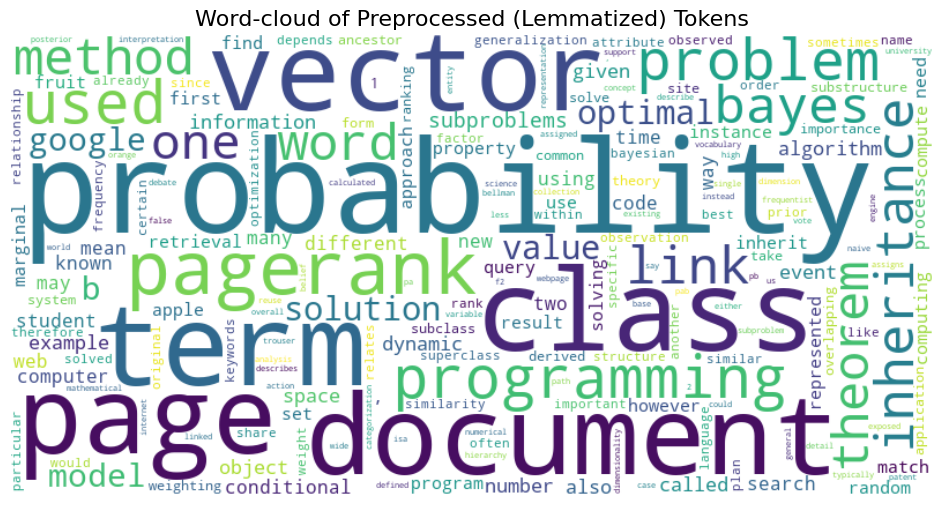

In [17]:
processed_dir = "processed"
all_texts = []
for category in ["originals","plagiarism"]:
    for fp in glob.glob(os.path.join(processed_dir, category, "*.txt")):
        with open(fp, encoding="utf-8") as f:
            all_texts.append(f.read())

tokens = " ".join(all_texts).split()
freqs  = Counter(tokens)
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    max_words=200
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word-cloud of Preprocessed (Lemmatized) Tokens", fontsize=16)
plt.show()

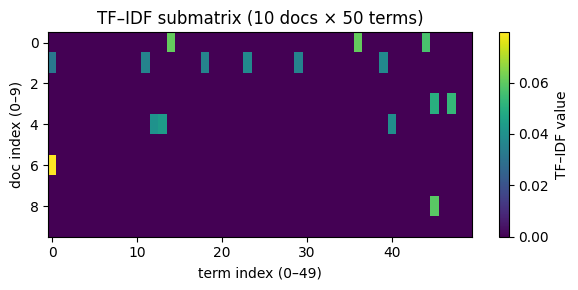

In [18]:
slice_ = tfidf_matrix[:10, :50].toarray()

plt.figure(figsize=(6,3))
plt.imshow(slice_, aspect='auto', interpolation='nearest')
plt.colorbar(label="TF–IDF value")
plt.xlabel("term index (0–49)")
plt.ylabel("doc index (0–9)")
plt.title("TF–IDF submatrix (10 docs × 50 terms)")
plt.tight_layout()
plt.show()

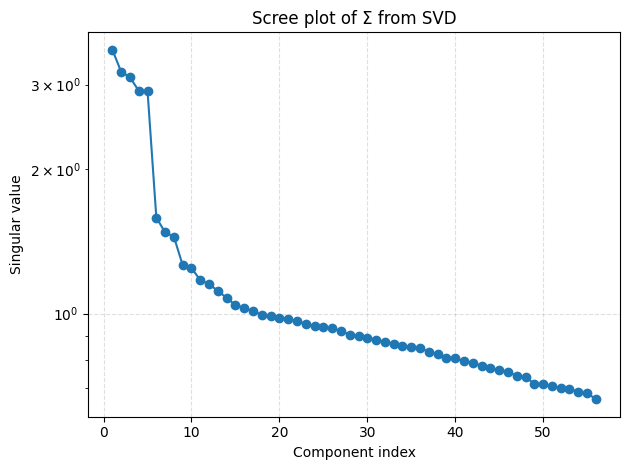

In [19]:
plt.figure()
plt.plot(np.arange(1, len(sigma)+1), sigma, marker='o')
plt.yscale("log")
plt.xlabel("Component index")
plt.ylabel("Singular value")
plt.title("Scree plot of Σ from SVD")
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

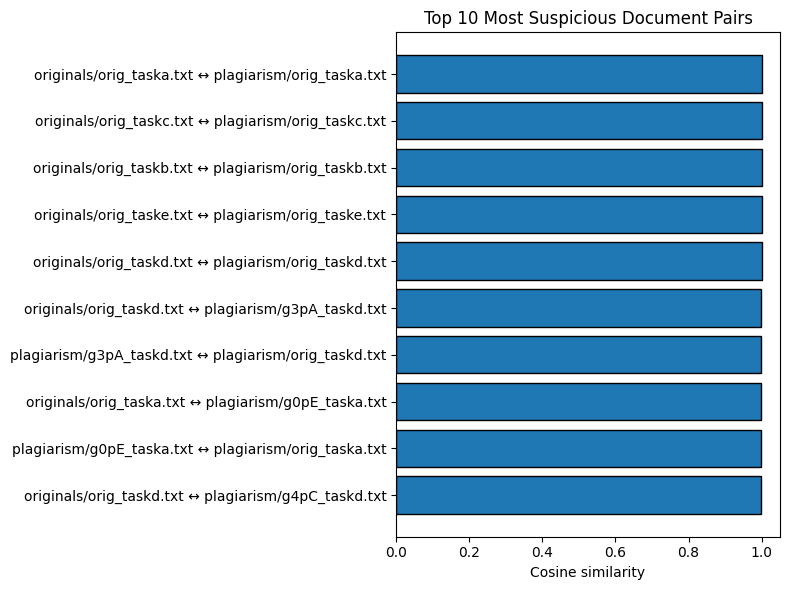

In [20]:
docs = df_pairwise3.index.tolist()
pairs = []
for i in range(len(docs)):
    for j in range(i+1, len(docs)):
        pairs.append(((docs[i], docs[j]), df_pairwise3.iat[i, j]))

pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
top_n = 10
top_pairs = pairs[:top_n]
labels = [f"{i} ↔ {j}" for (i, j), _ in top_pairs]
scores = [score for _, score in top_pairs]

plt.figure(figsize=(8, 6))
bars = plt.barh(labels, scores, edgecolor='k')
plt.xlabel("Cosine similarity")
plt.title(f"Top {top_n} Most Suspicious Document Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Metrics
#### Let us now use the third, most optimal benchmark dataset (medium in size, with good labeling.)
#### First, let's take a look at the correct file labels:
#### (Task is the original file, from which the one in first column is supposedly plagiarising.)

#### **NOTE**: Heavy in this context DOES NOT mean heavy plagiarism, but heavy PARAPHRASAL, which makes it LESS similar to the original. Light - little to none of rewording, so similar. Cut - extremely similar.
#### Non - NOT a plagiarised document.

#### This is a four-class classification. To see a simple plagiarism - non-plagiarism, please scroll lower.

In [21]:
pd.set_option('display.max_rows', None)
df_pairwise3.columns = df_pairwise3.columns.str.replace(r'^originals/', '', regex=True)
df_pairwise3.index = df_pairwise3.index.str.replace(r'^plagiarism/', '', regex=True)
df_sorted = df_pairwise3.sort_index()
task_params = ['taska.txt', 'taskb.txt', 'taskc.txt', 'taskd.txt', 'taske.txt']
results = []

for task in task_params:
    cols = df_sorted.columns[df_sorted.columns.str.endswith(task)]
    rows = df_sorted.index[df_sorted.index.str.endswith(task)]
    filtered_df = df_sorted.loc[rows, cols]
    df_task = filtered_df.iloc[:-1, :1].copy(deep=True)
    df_task['File'] = df_task.index
    df_task.columns = ['Value', 'File']
    df_task = df_task[['File', 'Value']]
    file_path = 'file_information.csv'
    df_scv = pd.read_csv(file_path)
    df_task = df_task.merge(df_scv[['File', 'Category']], on='File', how='left')
    df_task['Task'] = task
    results.append(df_task)
final_result = pd.concat(results, ignore_index=True)
final_result

,File,Value,Category,Task
0,g0pA_taska.txt,0.235438,non,taska.txt
1,g0pB_taska.txt,0.197944,non,taska.txt
2,g0pC_taska.txt,0.500123,heavy,taska.txt
3,g0pD_taska.txt,0.935630,cut,taska.txt
4,g0pE_taska.txt,0.998811,light,taska.txt
5,g1pA_taska.txt,0.382949,non,taska.txt
6,g1pB_taska.txt,0.187011,non,taska.txt
7,g1pD_taska.txt,0.659006,light,taska.txt
8,g2pA_taska.txt,0.181121,non,taska.txt
9,g2pB_taska.txt,0.233111,non,taska.txt


In [22]:
#F1 Score
df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'non': 0, 'heavy': 2, 'light': 1, 'cut': 3}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)
df_clean = df_clean.dropna(subset=['TrueLabel']).copy()
df_clean['TrueLabel'] = df_clean['TrueLabel'].astype(int)

def predict_labels(scores, t1, t2, t3):
    preds = []
    for s in scores:
        if s < t1:
            preds.append(0)  #non
        elif s < t2:
            preds.append(2)  #light
        elif s < t3:
            preds.append(1)  #heavy
        else:
            preds.append(3)  #cut
    return preds

best_f1 = 0
best_thresholdsf1 = (0, 0, 0)
for t1 in np.linspace(0, 1, 20):
    for t2 in np.linspace(0, 1, 20):
        for t3 in np.linspace(0, 1, 20):
            if t1 < t2 < t3:
                preds = predict_labels(df_clean['Value'], t1, t2, t3)
                f1 = f1_score(df_clean['TrueLabel'], preds, average='macro')
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresholdsf1 = (t1, t2, t3)

print("Best F1 score:", best_f1)
print("Best thresholds (t1, t2, t3):", best_thresholdsf1)

Best F1 score: 0.44721933093823096
Best thresholds (t1, t2, t3): (0.5263157894736842, 0.8421052631578947, 0.9473684210526315)


In [23]:
#Precision
df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)
df_clean = df_clean.dropna(subset=['TrueLabel']).copy()
df_clean['TrueLabel'] = df_clean['TrueLabel'].astype(int)

def predict_labels(scores, t1, t2, t3):
    preds = []
    for s in scores:
        if s < t1:
            preds.append(0)  # non
        elif s < t2:
            preds.append(2)  # light
        elif s < t3:
            preds.append(1)  # heavy
        else:
            preds.append(3)  # cut
    return preds

lb = LabelBinarizer()
lb.fit(df_clean['TrueLabel'])
best_ap = 0
best_thresholdsp1 = (0, 0, 0)

for t1 in np.linspace(0, 1, 20):
    for t2 in np.linspace(0, 1, 20):
        for t3 in np.linspace(0, 1, 20):
            if t1 < t2 < t3:
                preds = predict_labels(df_clean['Value'], t1, t2, t3)
                preds_binarized = lb.transform(preds).astype(int)
                ap = average_precision_score(lb.transform(df_clean['TrueLabel']), preds_binarized, average='macro')
                if ap > best_ap:
                    best_ap = ap
                    best_thresholdsp1 = (t1, t2, t3)

print("Best Average Precision score:", best_ap)
print("Best thresholds (t1, t2, t3):", best_thresholdsp1)

Best Average Precision score: 0.39675357985607296
Best thresholds (t1, t2, t3): (0.42105263157894735, 0.7368421052631579, 0.8421052631578947)


In [24]:
#Recall
df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)
df_clean = df_clean.dropna(subset=['TrueLabel']).copy()
df_clean['TrueLabel'] = df_clean['TrueLabel'].astype(int)

def predict_labels(scores, t1, t2, t3):
    preds = []
    for s in scores:
        if s < t1:
            preds.append(0)  # non
        elif s < t2:
            preds.append(2)  # light
        elif s < t3:
            preds.append(1)  # heavy
        else:
            preds.append(3)  # cut
    return preds

lb = LabelBinarizer()
lb.fit(df_clean['TrueLabel'])
best_recall = 0
best_thresholdsr1 = (0, 0, 0)

for t1 in np.linspace(0, 1, 20):
    for t2 in np.linspace(0, 1, 20):
        for t3 in np.linspace(0, 1, 20):
            if t1 < t2 < t3:
                preds = predict_labels(df_clean['Value'], t1, t2, t3)
                preds_binarized = lb.transform(preds).astype(int)
                recall = recall_score(lb.transform(df_clean['TrueLabel']), preds_binarized, average='macro')
                if recall > best_recall:
                    best_recall = recall
                    best_thresholdsr1 = (t1, t2, t3)

print("Best Recall score:", best_recall)
print("Best thresholds (t1, t2, t3):", best_thresholdsr1)


Best Recall score: 0.4934210526315789
Best thresholds (t1, t2, t3): (0.631578947368421, 0.7368421052631579, 0.8421052631578947)


# Metrics - Part 2.

### Usually, we only need to know whether the document is plagiarised, not to what degree, so:

In [25]:
final_result['Category'] = final_result['Category'].apply(lambda x: 'no' if 'non' in str(x).lower() else 'yes')
final_result

,File,Value,Category,Task
0,g0pA_taska.txt,0.235438,no,taska.txt
1,g0pB_taska.txt,0.197944,no,taska.txt
2,g0pC_taska.txt,0.500123,yes,taska.txt
3,g0pD_taska.txt,0.935630,yes,taska.txt
4,g0pE_taska.txt,0.998811,yes,taska.txt
5,g1pA_taska.txt,0.382949,no,taska.txt
6,g1pB_taska.txt,0.187011,no,taska.txt
7,g1pD_taska.txt,0.659006,yes,taska.txt
8,g2pA_taska.txt,0.181121,no,taska.txt
9,g2pB_taska.txt,0.233111,no,taska.txt


In [26]:
#F1 score
df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'no': 0, 'yes': 1}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)

def predict_labels(scores, t1):
    preds = []
    for s in scores:
        if s < t1:
            preds.append(0)  # no
        else:
            preds.append(1)  # yes
    return preds

best_f1 = 0
best_threshold = 0
for t1 in np.linspace(0, 1, 20):
    preds = predict_labels(df_clean['Value'], t1)
    f1 = f1_score(df_clean['TrueLabel'], preds, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t1
tf1 = best_threshold
print("Best F1 score:", best_f1)
print("Best threshold (t1):", best_threshold)

Best F1 score: 0.829059829059829
Best threshold (t1): 0.42105263157894735


In [27]:
#Precision

df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'no': 0, 'yes': 1}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)

def predict_labels(scores, t1):
    return [0 if s < t1 else 1 for s in scores]
best_ap = 0
best_threshold = 0

for t1 in np.linspace(0, 1, 100):
    preds = predict_labels(df_clean['Value'], t1)
    ap = average_precision_score(df_clean['TrueLabel'], preds)
    if ap > best_ap:
        best_ap = ap
        best_threshold = t1

tp = best_threshold
print("Best Average Precision score:", best_ap)
print("Best threshold (t1):", best_threshold)


Best Average Precision score: 0.8958064516129032
Best threshold (t1): 0.6464646464646465


In [28]:
#Recall

df = final_result.copy(deep=True)
df_clean = df.dropna(subset=['Category']).copy()
label_map = {'no': 0, 'yes': 1}
df_clean['TrueLabel'] = df_clean['Category'].map(label_map)

def predict_labels(scores, t1):
    return [0 if s < t1 else 1 for s in scores]
thresholds = np.linspace(tf1, tp, 200)
recall_threshold_pairs = []

for t1 in thresholds:
    preds = predict_labels(df_clean['Value'], t1)
    recall = recall_score(df_clean['TrueLabel'], preds, average='binary')
    recall_threshold_pairs.append((recall, t1))
max_recall = max(r for r, _ in recall_threshold_pairs)
best_threshold = max(t for r, t in recall_threshold_pairs if r == max_recall)

print("Best Recall score:", max_recall)
print("Best threshold (t1):", best_threshold)

Best Recall score: 0.967741935483871
Best threshold (t1): 0.4221853552718403


# Final result - plagiarism verdict for Corpuses.

#### **Note**: only for corpuses 1, 2 and 3 in binary-case classification.

In [29]:
def label_cosine_similarity_results(df_similarities: pd.DataFrame, threshold: float = None) -> pd.DataFrame:
    rows, cols = df_similarities.shape
    if threshold is None:
        threshold = 0.6 if rows * cols < 400 else 0.3
    labeled_df = df_similarities.applymap(
        lambda sim: "Suspected for Plagiarism"
        if sim >= threshold
        else "Not enough evidence to conclude plagiarism"
    )  
    print(labeled_df)

In [30]:
labeled = label_cosine_similarity_results(df_pairwise1, None)

                                               originals/original1.txt  \
originals/original1.txt                       Suspected for Plagiarism   
originals/original2.txt     Not enough evidence to conclude plagiarism   
originals/original3.txt     Not enough evidence to conclude plagiarism   
originals/original4.txt     Not enough evidence to conclude plagiarism   
plagiarism/plagiarism1.txt                    Suspected for Plagiarism   
plagiarism/plagiarism2.txt  Not enough evidence to conclude plagiarism   
plagiarism/plagiarism3.txt  Not enough evidence to conclude plagiarism   
plagiarism/plagiarism4.txt  Not enough evidence to conclude plagiarism   

                                               originals/original2.txt  \
originals/original1.txt     Not enough evidence to conclude plagiarism   
originals/original2.txt                       Suspected for Plagiarism   
originals/original3.txt     Not enough evidence to conclude plagiarism   
originals/original4.txt     Not enoug

C:\Users\user\AppData\Local\Temp\ipykernel_14952\1220538865.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labeled_df = df_similarities.applymap(


In [31]:
labeled = label_cosine_similarity_results(df_pairwise2, None)
print(labeled)

                                                 originals/source-document00001.txt  \
originals/source-document00001.txt                         Suspected for Plagiarism   
originals/source-document00002.txt       Not enough evidence to conclude plagiarism   
originals/source-document00003.txt                         Suspected for Plagiarism   
originals/source-document00004.txt       Not enough evidence to conclude plagiarism   
originals/source-document00005.txt       Not enough evidence to conclude plagiarism   
originals/source-document00006.txt                         Suspected for Plagiarism   
originals/source-document00007.txt       Not enough evidence to conclude plagiarism   
originals/source-document00008.txt       Not enough evidence to conclude plagiarism   
originals/source-document00009.txt       Not enough evidence to conclude plagiarism   
originals/source-document00010.txt                         Suspected for Plagiarism   
originals/source-document00011.txt       No

C:\Users\user\AppData\Local\Temp\ipykernel_14952\1220538865.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labeled_df = df_similarities.applymap(


In [32]:
labeled = label_cosine_similarity_results(df_pairwise3, tf1)
print(labeled)

                                                      orig_taska.txt  \
originals/orig_taska.txt                    Suspected for Plagiarism   
originals/orig_taskb.txt  Not enough evidence to conclude plagiarism   
originals/orig_taskc.txt  Not enough evidence to conclude plagiarism   
originals/orig_taskd.txt  Not enough evidence to conclude plagiarism   
originals/orig_taske.txt  Not enough evidence to conclude plagiarism   
g0pA_taska.txt            Not enough evidence to conclude plagiarism   
g0pA_taskb.txt            Not enough evidence to conclude plagiarism   
g0pA_taskc.txt            Not enough evidence to conclude plagiarism   
g0pA_taskd.txt            Not enough evidence to conclude plagiarism   
g0pA_taske.txt            Not enough evidence to conclude plagiarism   
g0pB_taska.txt            Not enough evidence to conclude plagiarism   
g0pB_taskb.txt            Not enough evidence to conclude plagiarism   
g0pB_taskc.txt            Not enough evidence to conclude plagia

C:\Users\user\AppData\Local\Temp\ipykernel_14952\1220538865.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labeled_df = df_similarities.applymap(
